# Bayesian Logistic Regression Applied to Candidemia data

The purpose of this notebook is to apply a Bayesian analysis to Candidemia dataset.

In [4]:
#Import libraries 

import os
import pymc as pm
import arviz as az 
import bambi as bm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (roc_curve, roc_auc_score, 
confusion_matrix, accuracy_score, 
f1_score,precision_recall_curve)

In [6]:
#Import functions to retrieve data from Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

#Set authentification and dirve
gauth = GoogleAuth()
drive = GoogleDrive(gauth)

#Find the Dataset on GoogleDrive 
fileList = drive.ListFile({'q': "title = 'data_candidemia.csv' and trashed=false"}).GetList()
for file1 in fileList:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=802110240157-db4lvf4ksr1sv69n2c3ubrj2cq963lgc.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.
title: data_candidemia.csv, id: 1y2neUuK258lxhJt8WqsGjFpXjWEA1yjR


In [8]:
#Get data from Google Drive

#Get the id from CSV file
file_id = fileList[0]['id']
file = drive.CreateFile({'id':file_id})
file.GetContentFile('data_candidemia.csv')

#Convert it to a DataFrame
df = pd.read_csv('data_candidemia.csv', engine='python')
#Print the first row
df.head(1)

,Idade,Sexo,Tempo de Internação,Cultura,CAR,Dispositivo Central,Tempo em UTI,Jejum,Nutrição Parental,Dialisis,...,SEPSE qSOFA,Choque Septico,Candidiase Diseminada,Tratamento Antifungico,TAT-Dias,Retirada Cateter,RC-3Dias,Resposta Antifungico,Obito Precoce,Obito Tardio
0,135,1,144.0,2,0,0,51.0,0,0,0,...,0,0,0,1,16,0,0,2,0,0


In [10]:
#Prepare the data

#Clone the data
data=df[:]

#Drop unnecessary columns
data = data.drop(['Tempo de Internação', 'Obito Precoce', 'Obito Tardio'], axis=1)

#Dummy coding for categorical features
for i in data.drop(['Idade', 'Tempo em UTI', 'TAT-Dias'], axis=1).columns:
    if len(set(df[i].values)) > 2:
        data = pd.get_dummies(data=data, columns=[i], dtype=int)

#New column's name
new_names = ['Age','Gender','Culture','Recent Abdominal Surgery (within 30 days)','Central Venous Device (CVC, PICC, Hickman, Broviac, Semi-Implantable)',
            'Time in ICU','Fasting Status','Parenteral Nutrition','Dialysis During Candidemia','Mechanical Ventilation','Antibiotic (Vancomycin)',
            'Broad-Spectrum Antibiotic','Prior Use of Azoles','Previous Bacteremia (30 days or at candidemia onset)','Prematurity','Malignancy',
            'Short Bowel','Benign Hematologic Diseases','Inborn Error of Immunity','Neurological Sequelae','Heart Disease', 'Others*',
            'Septic Shock - use of amines', 'Complete Antifungal Treatment in days','Duration of Candidemia <= 2 Days',
            'Duration of Candidemia 3-7 Days', 'Duration of Candidemia >8 Days', 'Duration of Candidemia - Unknown','No SEPSE qSOFA','SEPSE qSOFA',
            'SEPSE qSOFA Unknown','No Disseminated Candidiasis','Disseminated Candidiasis', 'Disseminated Candidiasis Unknown','No Antifungal Treatment',
            'Antifungal Treatment - Azoles','Antifungal Treatment - Amphotericin','Antifungal Treatment - Echinocandidae','Antifungal Treatment - Combination',
            'Catheter Not Removed','Catheter Removed','Catheter Removal Unknown','Catheter Not Removed in the First 3 Days of Candidemia',
            'Catheter Removed in the First 3 Days of Candidemia','Catheter Removed in the First 3 Days of Candidemia - Unknown',
            'Antifungal Response - FAILURE', 'Antifungal Response <72H', 'Antifungal Response 4-7 Days','Antifungal Response >7 Days', 'Antifungal Response - Unknown']

#Rename columns
for i,j in enumerate(data.drop(['Neutropenia'],axis=1).columns):
    data=data.rename({j:new_names[i]},axis=1)

#Create ICU Status colmun
icu=[]
for i in data['Time in ICU'].values:
    if i > 0:
        icu.append(1)
    else:
        icu.append(0)
#Insert it to the main dataframe
data['ICU']=icu

#Check that ICU was added
data.loc[0:3,['Gender', 'ICU']]

,Gender,ICU
0,1,1
1,1,0
2,0,1
3,0,0


# Extract Relevant Features

In the last notebook we plot and check correlation among the features, on this notebook we are gonna jump straight to extract the relevant features.

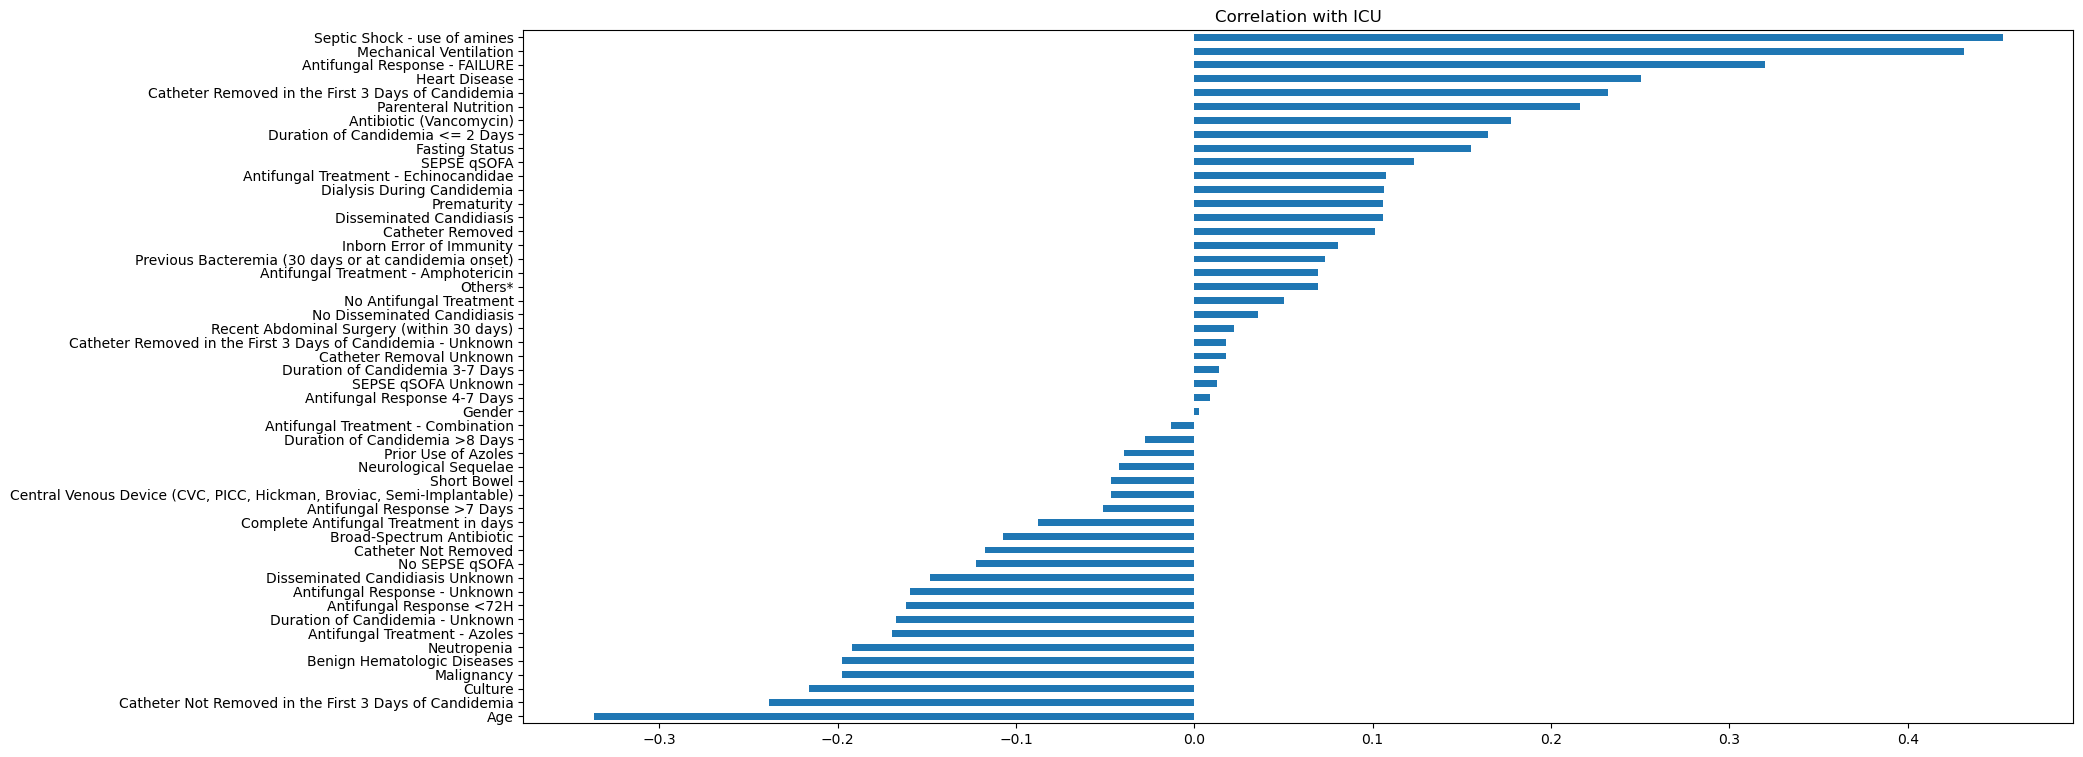

Age                                                                     -0.336700
Catheter Not Removed in the First 3 Days of Candidemia                  -0.238499
Culture                                                                 -0.215772
Malignancy                                                              -0.197442
Benign Hematologic Diseases                                             -0.197442
Neutropenia                                                             -0.191855
Antifungal Treatment - Azoles                                           -0.169494
Duration of Candidemia - Unknown                                        -0.167358
Antifungal Response <72H                                                -0.161716
Antifungal Response - Unknown                                           -0.159345
Disseminated Candidiasis Unknown                                        -0.148047
No SEPSE qSOFA                                                          -0.122312
Catheter Not Rem

In [9]:
#Features that correlate with ICU status
data.drop(['Time in ICU', 'ICU'],axis=1).corrwith(data.ICU).sort_values(ascending=True).plot(kind= 'barh', figsize=(20,9))
plt.title('Correlation with ICU')
plt.show()

#Print the R2 coefficients
data.drop(['Time in ICU', 'ICU'],axis=1).corrwith(data.ICU).sort_values(ascending=True)

As we can see on the outcomes, most of the features are weakly correlated with ICU status. To extract the relevant features we are gonna consider the ones with a positive correlation equal or higher than 0.1 and for negative correlation equal or smaller than -0.1.

In [12]:
#Extract relevant features

#ICU correlation columnt
correlation_target = data.drop(['Time in ICU'],axis=1).corr().ICU

#Extract relevant features
relevant_feat= correlation_target[(correlation_target <= -0.1) | (correlation_target >= 0.1)]
relevant_feat.sort_values(ascending=True)

Age                                                      -0.336700
Catheter Not Removed in the First 3 Days of Candidemia   -0.238499
Culture                                                  -0.215772
Benign Hematologic Diseases                              -0.197442
Malignancy                                               -0.197442
Neutropenia                                              -0.191855
Antifungal Treatment - Azoles                            -0.169494
Duration of Candidemia - Unknown                         -0.167358
Antifungal Response <72H                                 -0.161716
Antifungal Response - Unknown                            -0.159345
Disseminated Candidiasis Unknown                         -0.148047
No SEPSE qSOFA                                           -0.122312
Catheter Not Removed                                     -0.117412
Broad-Spectrum Antibiotic                                -0.107524
Catheter Removed                                          0.10

# Variance Inflation Factor (VIF)

In [12]:
#Let's create the function to apply VIF

#Import library
from sklearn.linear_model import LinearRegression

#Define the function
def calculate_vif(data, features):
    vif, tolerance= {},{}
    #Extract all the relevant features
    for feature in features:
        #Retrieve the relevant features
        X= [f for f in features if f != feature]

        #X contains all the predictors except one, y contains that predictor to be regressed against
        X,y= data[X], data[feature]

        #R2
        r2= LinearRegression().fit(X,y).score(X,y)

        #Tolerance 
        tolerance[feature] = 1 - r2

        #VIF
        vif[feature]= 1/1-tolerance[feature]
    #Return
    return pd.DataFrame({'VIF': vif, 'Tolerance': tolerance})

In [14]:
#Calculate the VIF
calculate_vif(data=data, features=relevant_feat.drop(['ICU'], axis=0).index)

,VIF,Tolerance
Age,0.491034,0.508966
Culture,0.291295,0.708705
Fasting Status,0.487094,0.512906
Parenteral Nutrition,0.553963,0.446037
Dialysis During Candidemia,0.329564,0.670436
Mechanical Ventilation,0.515259,0.484741
Antibiotic (Vancomycin),0.361375,0.638625
Broad-Spectrum Antibiotic,0.251671,0.748329
Neutropenia,0.558142,0.441858
Prematurity,0.265844,0.734156


All features are perfectly independent, good sign to begging with the bayesian analysis.

# Bayesian approach applied to relevant features

Due to the large number of predictors relative to the limited number of subjects in the dataset, fitting a fully saturated multivariable logistic regression model is statistically inappropriate and may lead to unstable or non-identifiable parameter estimates. In this context, including all predictors with dummy variables simultaneously can inflate posterior uncertainty, reduce effective sample size, and generate divergences during sampling, indicating that the model is over-parameterized relative to the available information. For these reasons, it is necessary to limit the number of predictors and fit a more parsimonious model. 

To avoid any issue while fitting the model, one dummy-coded variable it's gonna be chosen among the features with more than 2 categories. In this case, we are gonna keep:

- **Catheter Removed**
- **Duration of Candidemia <=2 Days**
- **Antifungal Response <72H**
- **Antifungal Response - Unknown**
- **Catheter Removed in the First 3 Days of Candidemia**

### Antifungal Response - FAILURE Case

Taking into account the last notebook where a classic Logistic Regression was applied, on that notebook we can notice that Antifungal Response - FAILURE has a problem with *quase-complete separation*, because of that this feature it's gonna be removed from all studies. Here is the crosstab that validates this information.

In [149]:
#Crosstab Antifungal Response - FAILURE vs ICU status
pd.crosstab(data['Antifungal Response - FAILURE'],data.ICU)

ICU,0,1
Antifungal Response - FAILURE,,
0,35,44
1,1,18


In [14]:
#Fit a Logistic Regression with a Bayesian approach
mu= 0
sigma= 1 #1 1.5

#Standarize Age
standarize_age= (data.Age - data.Age.mean())/ data.Age.std()
#Alternative:
#for i in data.Age:
#    standarize_age.append((i - np.mean(data.Age))/np.std(data.Age))

with pm.Model() as relevant_feat_model:

    #Priors with weakly informative normal distributions
    beta_0 = pm.Normal('beta_0', mu= mu, sigma= sigma)
    beta_Age = pm.Normal('beta_Age', mu= mu, sigma= sigma)
    beta_Culture = pm.Normal('beta_Culture', mu= mu, sigma= sigma)
    beta_Fasting_Status= pm.Normal('beta_Fasting_Status', mu= mu, sigma= sigma)
    beta_Parenteral_Nutrition = pm.Normal('beta_Parenteral_Nutrition', mu= mu, sigma= sigma)
    beta_Dialysis_During_Candidemia = pm.Normal('beta_Dialysis_During_Candidemia', mu= mu, sigma= sigma)
    beta_Mechanical_Ventilation = pm.Normal('beta_Mechanical_Ventilation', mu= mu, sigma= sigma)
    beta_Antibiotic = pm.Normal('beta_Antibiotic', mu= mu, sigma= sigma)
    beta_Broad_Spectrum_Antibiotic = pm.Normal('beta_Broad_Spectrum_Antibiotic', mu= mu, sigma= sigma)
    beta_Neutropenia = pm.Normal('beta_Neutropenia', mu= mu, sigma= sigma)
    beta_Prematurity = pm.Normal('beta_Prematurity', mu= mu, sigma= sigma)
    beta_Malignancy = pm.Normal('beta_Malignancy', mu= mu, sigma= sigma)
    beta_Benign_Hematologic_Diseases = pm.Normal('beta_Benign_Hematologic_Diseases', mu= mu, sigma= sigma)
    beta_Heart_Disease = pm.Normal('beta_Heart_Disease', mu= mu, sigma= sigma)
    beta_Septic_Shock = pm.Normal('beta_Septic_Shock', mu= mu, sigma= sigma)
    beta_Duration_Candidemia_less_2D = pm.Normal('beta_Duration_Candidemia_less_2D', mu= mu, sigma= sigma)
    beta_Duration_Candidemia_Unknown = pm.Normal('beta_Duration_Candidemia_Unknown', mu= mu, sigma= sigma)
    beta_No_SEPSE_qSOFA = pm.Normal('beta_No_SEPSE_qSOFA', mu= mu, sigma= sigma)
    beta_SEPSE_qSOFA = pm.Normal('beta_SEPSE_qSOFA', mu= mu, sigma= sigma)
    beta_Disseminated_Candidiasis = pm.Normal('beta_Disseminated_Candidiasis', mu= mu, sigma= sigma)
    beta_Azoles = pm.Normal('beta_Azoles', mu= mu, sigma= sigma)
    beta_Echinocandidae = pm.Normal('beta_Echinocandidae', mu= mu, sigma= sigma)
    beta_Catheter_Not_Removed = pm.Normal('beta_Catheter_Not_Removed', mu= mu, sigma= sigma)
    beta_Catheter_Removed = pm.Normal('beta_Catheter_Removed', mu= mu, sigma= sigma)
    beta_Catheter_Not_Removed_3Days = pm.Normal('beta_Catheter_Not_Removed_3Days', mu= mu, sigma= sigma)
    beta_Catheter_Removed_3Days = pm.Normal('beta_Catheter_Removed_3Days', mu= mu, sigma= sigma)
    beta_Antifungal_Response_FAILURE = pm.Normal('beta_Antifungal_Response_FAILURE', mu= mu, sigma= sigma)
    beta_Antifungal_Response_less72H = pm.Normal('beta_Antifungal_Response_less72H', mu= mu, sigma= sigma)
    beta_Antifungal_Response_Unknown = pm.Normal('beta_Antifungal_Response_Unknown', mu= mu, sigma= sigma)

    #Model fit
    p= pm.Deterministic('p', pm.math.sigmoid(beta_0 + beta_Age*standarize_age + beta_Culture*data.Culture + beta_Fasting_Status*data['Fasting Status']
                                                + beta_Parenteral_Nutrition*data['Parenteral Nutrition'] + beta_Dialysis_During_Candidemia*data['Dialysis During Candidemia']
                                                + beta_Mechanical_Ventilation*data['Mechanical Ventilation'] + beta_Antibiotic*data['Antibiotic (Vancomycin)']
                                                + beta_Broad_Spectrum_Antibiotic*data['Broad-Spectrum Antibiotic']
                                                + beta_Neutropenia*data['Neutropenia'] + beta_Prematurity*data.Prematurity + beta_Malignancy*data.Malignancy 
                                                + beta_Benign_Hematologic_Diseases*data['Benign Hematologic Diseases'] + beta_Heart_Disease*data['Heart Disease']
                                                + beta_Septic_Shock*data['Septic Shock - use of amines'] + beta_Duration_Candidemia_less_2D*data['Duration of Candidemia <= 2 Days']
                                                + beta_Duration_Candidemia_Unknown*data['Duration of Candidemia - Unknown'] #+ beta_No_SEPSE_qSOFA*data['No SEPSE qSOFA']
                                                + beta_SEPSE_qSOFA*data['SEPSE qSOFA'] + beta_Disseminated_Candidiasis*data['Disseminated Candidiasis'] + beta_Azoles*data['Antifungal Treatment - Azoles']
                                                + beta_Echinocandidae*data['Antifungal Treatment - Echinocandidae'] #+ beta_Catheter_Not_Removed*data['Catheter Not Removed']
                                                + beta_Catheter_Removed*data['Catheter Removed']#+ beta_Catheter_Not_Removed_3Days*data['Catheter Not Removed in the First 3 Days of Candidemia']
                                                + beta_Catheter_Removed_3Days*data['Catheter Removed in the First 3 Days of Candidemia'] #+ beta_Antifungal_Response_FAILURE*data['Antifungal Response - FAILURE']
                                                + beta_Antifungal_Response_less72H*data['Antifungal Response <72H'] + beta_Antifungal_Response_Unknown*data['Antifungal Response - Unknown']))


    #Likelihood
    pm.Bernoulli('ICU Admissions', p, observed=data.ICU)

In [16]:
#Sampling
with relevant_feat_model:
    idata= pm.sample(draws= 2000, tune= 1000, target_accept=0.95, random_seed=42, idata_kwargs={'log_likelihood':True})
sum = az.summary(idata)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_Age, beta_Culture, beta_Fasting_Status, beta_Parenteral_Nutrition, beta_Dialysis_During_Candidemia, beta_Mechanical_Ventilation, beta_Antibiotic, beta_Broad_Spectrum_Antibiotic, beta_Neutropenia, beta_Prematurity, beta_Malignancy, beta_Benign_Hematologic_Diseases, beta_Heart_Disease, beta_Septic_Shock, beta_Duration_Candidemia_less_2D, beta_Duration_Candidemia_Unknown, beta_No_SEPSE_qSOFA, beta_SEPSE_qSOFA, beta_Disseminated_Candidiasis, beta_Azoles, beta_Echinocandidae, beta_Catheter_Not_Removed, beta_Catheter_Removed, beta_Catheter_Not_Removed_3Days, beta_Catheter_Removed_3Days, beta_Antifungal_Response_FAILURE, beta_Antifungal_Response_less72H, beta_Antifungal_Response_Unknown]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.


In [18]:
#Print the summary
sum.iloc[0:29,:]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,0.212,0.805,-1.308,1.706,0.007,0.009,12930.0,5923.0,1.0
beta_Age,-0.414,0.321,-1.006,0.191,0.003,0.003,13401.0,6227.0,1.0
beta_Culture,-0.223,0.454,-1.117,0.603,0.004,0.005,12805.0,6391.0,1.0
beta_Fasting_Status,-0.321,0.561,-1.360,0.744,0.005,0.005,12562.0,6093.0,1.0
beta_Parenteral_Nutrition,0.427,0.541,-0.551,1.485,0.005,0.005,12394.0,5528.0,1.0
beta_Dialysis_During_Candidemia,0.484,0.834,-0.992,2.135,0.007,0.008,15423.0,5757.0,1.0
beta_Mechanical_Ventilation,1.088,0.581,0.007,2.185,0.005,0.004,13915.0,6254.0,1.0
beta_Antibiotic,0.415,0.571,-0.646,1.499,0.005,0.005,16036.0,6064.0,1.0
beta_Broad_Spectrum_Antibiotic,-0.846,0.626,-2.050,0.280,0.005,0.005,14157.0,5811.0,1.0
beta_Neutropenia,-0.372,0.622,-1.554,0.757,0.006,0.006,12480.0,6963.0,1.0


In [38]:
#Relevant findings
relevant_ind=[]
for i in sum.index[0:29]:
    if not (sum.loc[i,'hdi_3%'] < 0) & (sum.loc[i,'hdi_97%'] > 0):
        relevant_ind.append(i)
sum.loc[relevant_ind,:]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_Mechanical_Ventilation,1.088,0.581,0.007,2.185,0.005,0.004,13915.0,6254.0,1.0
beta_Septic_Shock,1.497,0.667,0.195,2.678,0.006,0.005,11212.0,6133.0,1.0


In [99]:
#Find the Posterior Odds Ratio

#Extract OR
or_samples, indexes=[],[]
for i in sum.iloc[0:29,:].index:
    if not (sum.loc[i,'hdi_3%'] < 0) & (sum.loc[i,'hdi_97%'] > 0):
        #Posterior samples of beta
        or_samples.append(np.exp(sum.loc[i,'mean']))
        #Indexes
        indexes.append(i)

#Find percentage
per=[]
for i in or_samples:
    per.append(round((i - 1)*100, 2))

#Copy dataframe
copy= sum.drop(['sd','mcse_mean','mcse_sd','ess_bulk','ess_tail'], axis=1).loc[indexes,:]

#Insert the new info to the dataframe
copy.insert(1, 'Posterior Odds Ratio', or_samples)
copy.insert(2, 'Percentage', per)

#Print relevant data
copy

,mean,Posterior Odds Ratio,Percentage,hdi_3%,hdi_97%,r_hat
beta_Mechanical_Ventilation,1.088,2.968331,196.83,0.007,2.185,1.0
beta_Septic_Shock,1.497,4.468264,346.83,0.195,2.678,1.0


**Interpretation**

After analyzing the results, it is important to highlight that all the features/covariates converge well. The parameter *r_hat* validates this statement because all the features got a r_hat of 1.

- **Mechanical Ventilation**</br>
*Posterior mean (log-OR) = 1.077*</br>
*94 % HDI = 0.106 – 2.188*</br>
*Posterior OR = exp(1.077) ≈ 2.94*</br>

After adjusting for all other covariates in the model, the odds of ICU admission among children with candidemia who required mechanical ventilation were an estimated 2.9 times the odds of ICU admission among those who did not require ventilation (94 % credible interval for the odds ratio: 1.11 – 8.91).
Because the entire HDI is positive, we assign high posterior probability (> 97 %) to a beneficial (in this case, risk-increasing) association between mechanical ventilation and ICU admission.

- **Septic Shock – use of amines**</br>
*Posterior mean (log-OR) = 1.482*</br>
*94 % HDI = 0.256 – 2.738*</br>
*Posterior OR = exp(1.482) ≈ 4.40*</br>

Children in septic shock treated with vaso-active amines exhibited an estimated 4.4-fold increase in the odds of ICU admission relative to children without this condition (94 % credible interval for the odds ratio: 1.29 – 15.46).
The entire HDI lies above zero, indicating strong posterior evidence that septic shock with amine support is associated with a materially higher risk of ICU transfer in the paediatric candidemia cohort.


/Users/diegovonborries/anaconda3/lib/python3.12/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (127), generating only 20 plots
  warnings.warn(


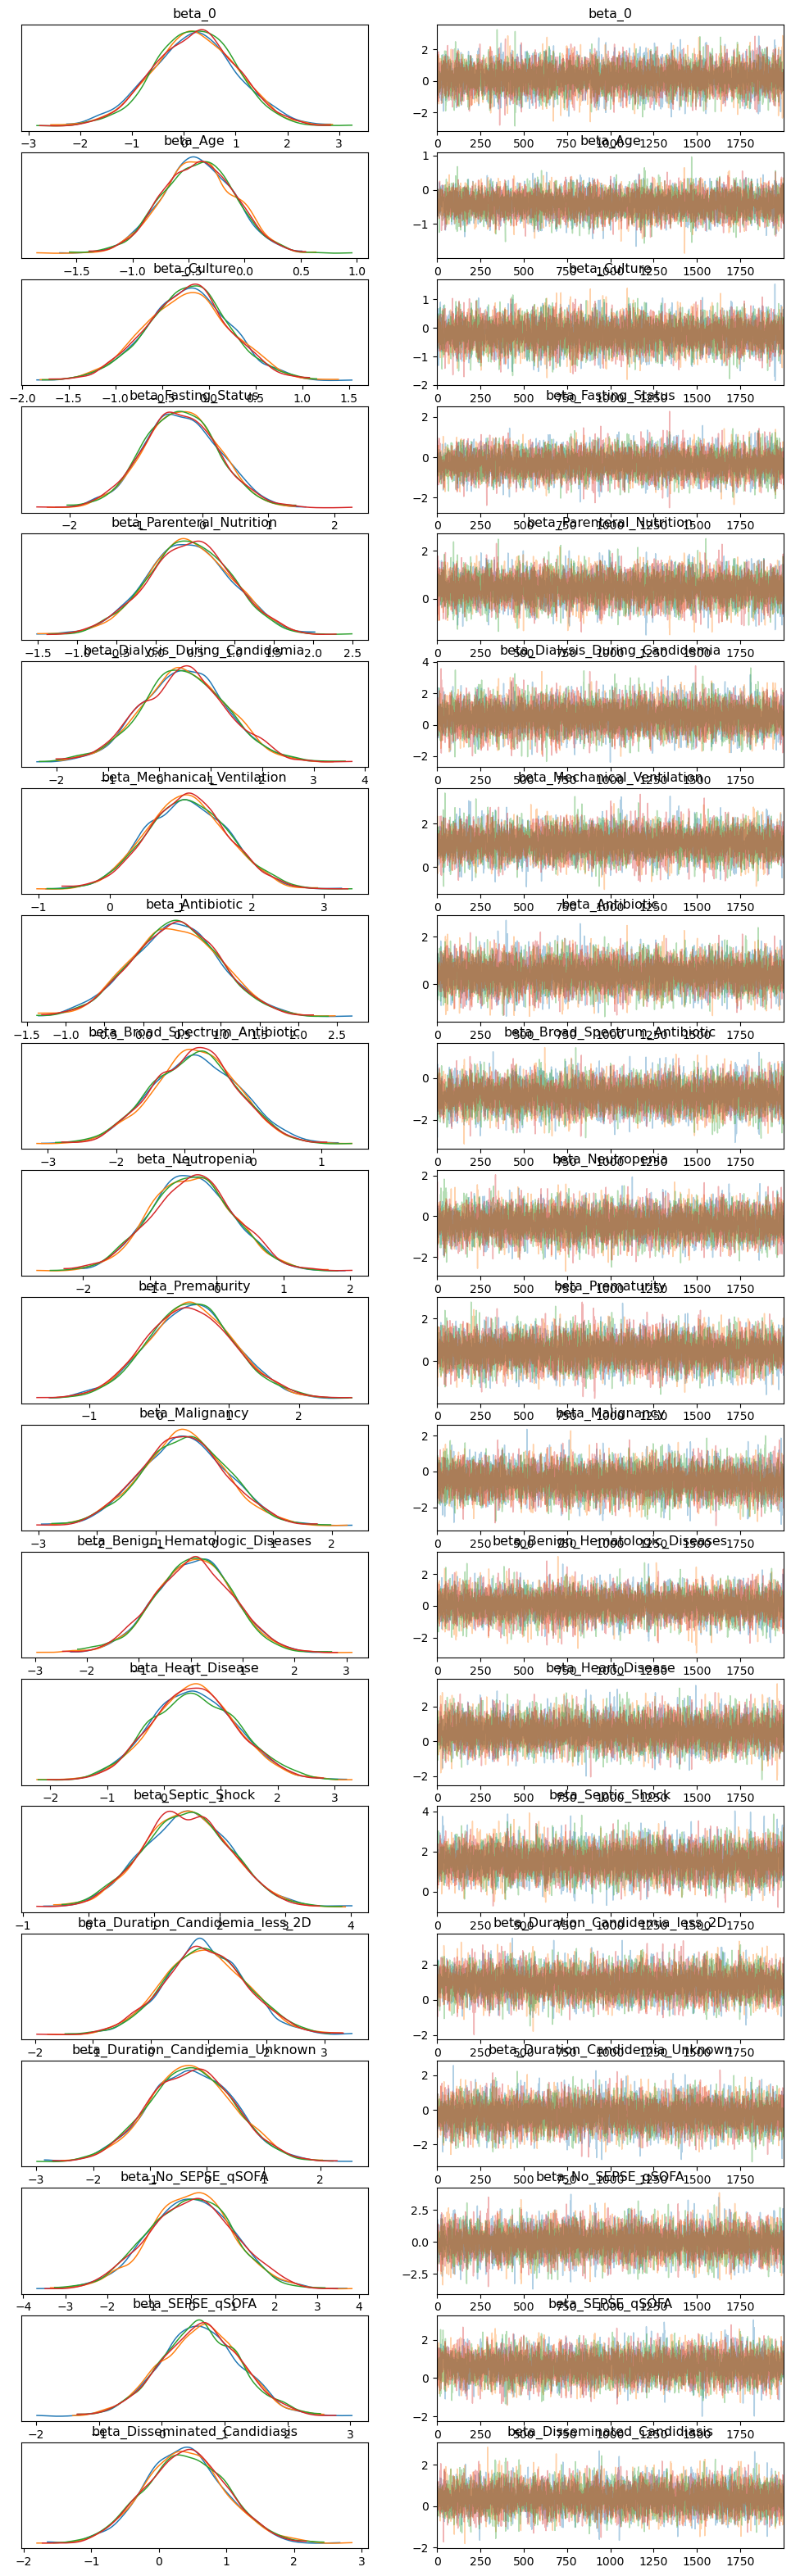

In [167]:
trace= az.plot_trace(idata,compact=False)

According with the plot, the algorithm does converge.

# Evaluation of the model

### Posterior Predictive Check (PPC)

Sampling: [ICU Admissions]


Output()

<Axes: xlabel='ICU Admissions'>

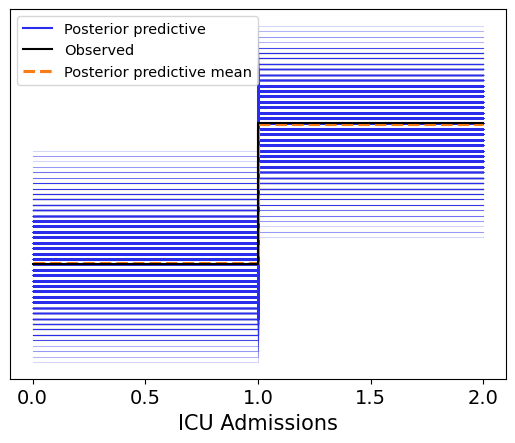

In [28]:
#Sample PPC
with relevant_feat_model:
    ppc = pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=42)

#Plot the PPC
plt.style.use('arviz-colors')
pm.plot_ppc(idata)
#, num_pp_samples= 300, mean=False)

The blue shaded region shows the kernel-density estimates of the ICU-admission rate across the posterior-replicated datasets; the solid black line marks the observed proportion in the real data. Because the black curve falls well inside the blue cloud, the model captures the empirical event rate and is considered well calibrated.

### Separation Plot

<Axes: >

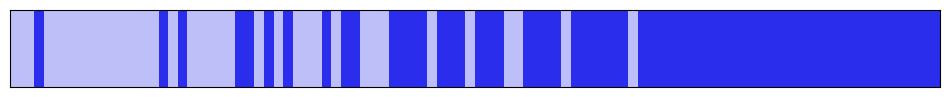

In [72]:
#Graph the separation plot
az.plot_separation(idata=ppc, y="ICU Admissions",figsize=(12,1))

**Interpretation of the Separation Plot**</br>

*Each bar* - one patient.</br>
*Light blue bars* - predicted low probability of ICU admission.</br>
*Dark blue bars* - actual ICU admissions (events), placed on the probability scale. </br>

- The first half of the plot is mostly light blue, with very few dark-blue event bars. This indicates that the model assigns low ICU risk to a large portion of the children, and—importantly—most of these patients indeed were not admitted to the ICU, leading to a good specificity.</br>

- Events represented by dark blue bars are concentrated toward the right side. This is exactly what good separation looks like: predicted high-risk patients include most of the real ICU admissions, meaning a good sensitivity in the high-risk region.</br>

- The far right of the plot is almost entirely dark blue indicating a subset of patients for whom the model assigns a very high predicted probability, and almost all of them did end up in the ICU. The model very confidently identifies the highest-risk group.</br>

- Some scattered dark-blue bars appear in the middle region. These are misclassified ICU admissions whose predicted probabilities were not extremely high. This is expected with small sample sizes and clinical heterogeneity.</br>

In summary, the model shows meaningful discriminative ability:</br>
- ICU admissions tend to cluster where predicted probabilities are high.</br>
- Misclassifications are present but not excessive.</br>
- Given the small sample size and high dimensionality of the dataset, this level of separation is actually quite reasonable.</br>
- The inclusion of only the predictors that showed meaningful correlation with ICU status seems to have improved separation by reducing model noise and instability.

### k̂ Parameter

This section is dedicated to find influential observations that can alter the outcome of the model, a Leav One Out cross validation it's gonna be used to identify if there is any influential observatio through the arviz function *loo*.

According with the literature, an observation is considered influental when its K_hat parameter or pareto parameter is bigger than 0.7.

/Users/diegovonborries/anaconda3/lib/python3.12/site-packages/arviz/plots/khatplot.py:184: FutureWarning: support for DataArrays will be deprecated, please use ELPDData.The reason for this, is that we need to know the numbers of drawssampled from the posterior
  warnings.warn(


<Axes: xlabel='Data Point', ylabel='Shape parameter k'>

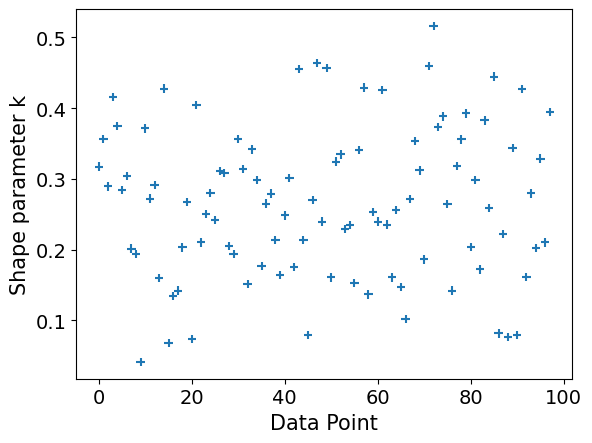

In [16]:
# compute pointwise LOO
loo = az.loo(idata)

#Plot k values
az.plot_khat(loo.pareto_k)#, show_bins=True)

As we can notice on the K_hat plot, all the observations are under 0.7, so we can claim there is no influential obersvations that could influence the model. There is only one point above 0.5, lets find that patient.

/Users/diegovonborries/anaconda3/lib/python3.12/site-packages/arviz/plots/khatplot.py:167: FutureWarning: support for arrays will be deprecated, please use ELPDData.The reason for this, is that we need to know the numbers of drawssampled from the posterior
  warnings.warn(


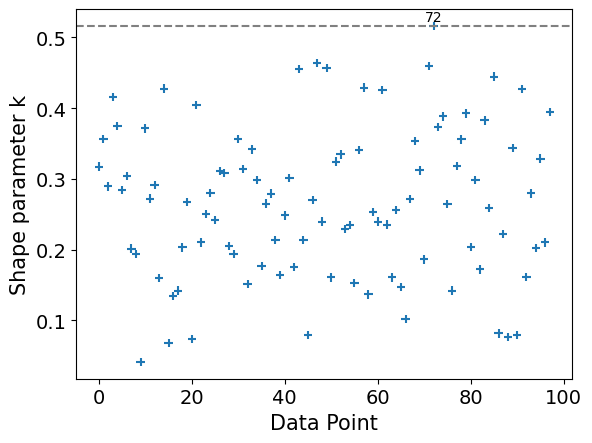

In [18]:
#Find the subject with the highest influential observation

ax= az.plot_khat(loo.pareto_k.values.ravel()) #ravel puts all the pareto values in one single array
sorted_kappas = np.sort(loo.pareto_k.values.ravel())

#Find the observation where the kappa value exceeds the threshold
threshold= sorted_kappas[-1:]
ax.axhline(threshold, ls='--', color= 'gray')
influential_obs= data.reset_index()[loo.pareto_k.values >= threshold].index

for i in influential_obs:
    y= loo.pareto_k.values[i]
    ax.text(i, y + 0.007, str(i), ha= 'center', va='baseline')

In [199]:
#Find the subject with the highest influential observation on the dataframe
data.iloc[influential_obs,:]

,Age,Gender,Culture,Recent Abdominal Surgery (within 30 days),"Central Venous Device (CVC, PICC, Hickman, Broviac, Semi-Implantable)",Time in ICU,Fasting Status,Parenteral Nutrition,Dialysis During Candidemia,Mechanical Ventilation,...,Catheter Removal Unknown,Catheter Not Removed in the First 3 Days of Candidemia,Catheter Removed in the First 3 Days of Candidemia,Catheter Removed in the First 3 Days of Candidemia - Unknown,Antifungal Response - FAILURE,Antifungal Response <72H,Antifungal Response 4-7 Days,Antifungal Response >7 Days,Antifungal Response - Unknown,ICU
72,25,0,1,0,1,0.0,1,1,0,1,...,0,1,0,0,0,0,0,0,1,0


In [66]:
#Print of the influential observation value
print('The highest kappa value is %s' % round(threshold[0],4))

The highest kappa value is 0.5164


In [70]:
#Function to convert age from months to years and months
def age_converter(age):
    year = age // 12
    months = age % 12
    return year,months
year,month = age_converter(25)
print('The subject with the highest influential observations is %s years and %s month old.' % (year,month))

The subject with the highest influential observations is 2 years and 1 month old.


The subject with the highest influential observation is a boy, he is 2 years old, and he was not admitted to the ICU. 

As we just mentioned before, for an influential observation to have a impact over the outcome of the model must have a kappa value greater than 0.7, in this case the influential value is around 0.5.

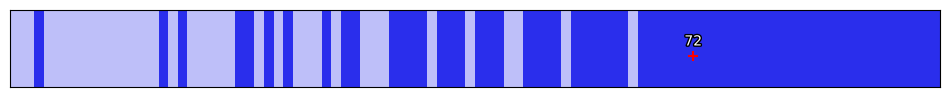

In [60]:
#Find the subject on the Separation graph
import matplotlib.patheffects as pe

#Create the separation plot
ax= az.plot_separation(idata=ppc, y='ICU Admissions', figsize=(12,1))

#Set the y axis position
y= np.random.uniform(low= 0.1, high= 0.7, size= len(influential_obs))

#Marke the highest kappa observation
for x,y in zip(influential_obs, y):
    #Printing of the value
    text= str(x)
    x= x/len(data)
    #Create the mark
    ax.scatter(x=x, y=y, marker= '+', s=50, color='red', zorder=3)
    ax.text(x=x, y= y + 0.1, s=text, color= 'white', ha='center', va='bottom',
           path_effects= [pe.withStroke(linewidth=2, foreground= 'black')])

One non-ICU patient appears in the extreme right tail of the separation plot. This indicates that, based on the predictors included in the model, this individual had a high posterior probability of ICU admission. However, the κ influence statistic for this observation was 0.51, substantially below the commonly used threshold of 0.7, indicating that the observation is not influential and does not distort the model.</br>
The presence of high-probability non-events is expected in probabilistic models, particularly in heterogeneous clinical datasets where patients with severe markers may ultimately not require ICU admission. Therefore, this case reflects model uncertainty rather than a model misspecification or failure. This is a classical false positive, and some false positives are expected in any probabilistic model.

### Forest Plot

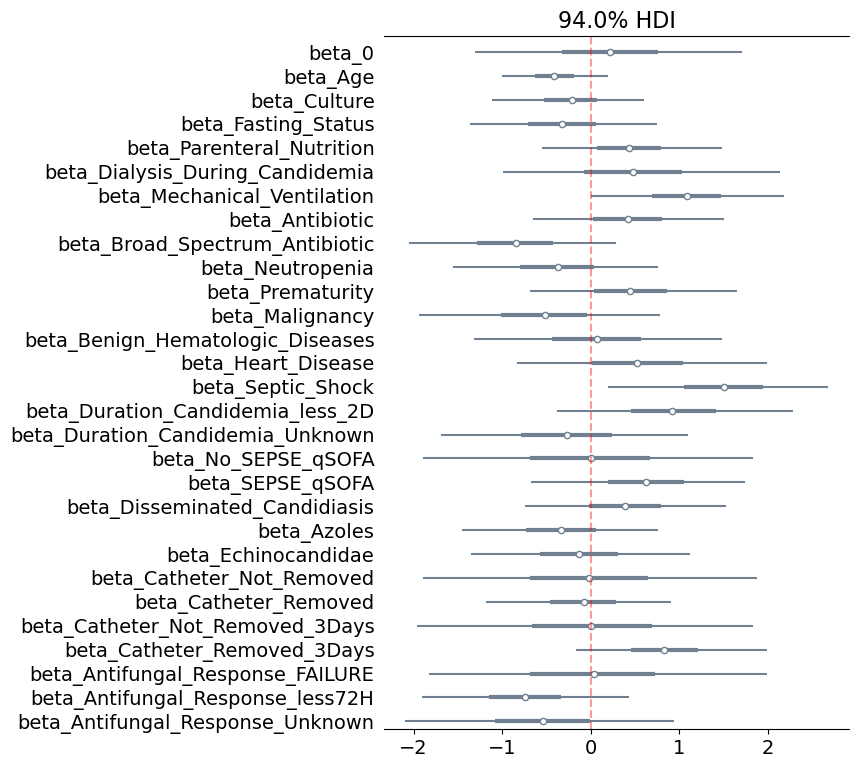

In [45]:
#Graph the Forest plot
az.plot_forest(idata, combined=True, colors= 'slategray', var_names=sum.index[0:29], figsize=(6,9))
plt.axvline(x=0, c= 'red', linestyle='--',alpha = 0.4)
plt.savefig('FRB_relevant.jpg',bbox_inches='tight')

The forest plot confirms the outcomes from the summary table, here we can see that the only features associated with ICU admissions are *Mechanical Ventilation* and *Septic Shock*, they both increase the odds of ICU admission.

### Confussion matrix

In [89]:
#Import library
from sklearn.metrics import classification_report

#Posterior-mean probability for each patient
y_prob = idata.posterior['p'].mean(('chain','draw')).values

#Bayes optimal hard call
#Element-wise threshold at 0.5 → True/False.
y_pred= (y_prob > 0.5).astype(int)

#Confussion matrix
print('Confusion Matrix \n',confusion_matrix(data.ICU, y_pred))
print(classification_report(data.ICU, y_pred, digits=3))

Confusion Matrix 
 [[26 10]
 [ 7 55]]
              precision    recall  f1-score   support

           0      0.788     0.722     0.754        36
           1      0.846     0.887     0.866        62

    accuracy                          0.827        98
   macro avg      0.817     0.805     0.810        98
weighted avg      0.825     0.827     0.825        98



The model demonstrates strong discriminative performance for predicting ICU admission among pediatric patients with candidemia. It correctly identifies 88.7% of true ICU cases (high recall), while maintaining a precision of 84.6%, indicating few false alarms. Although performance for the non-ICU class is slightly lower (recall 72.2%), the model prioritizes correctly identifying high-risk patients, which is clinically desirable. Overall accuracy is 82.7%, and the F1-scores indicate balanced and robust classification for both classes.

### Area Under the Curve

In [103]:
#Pack both values on a dictionary
pred_scores = dict(y_true=data.ICU, y_score=y_pred)
#Perform AUC
print(f'AUC = {roc_auc_score(**pred_scores):.4f}')

AUC = 0.8047


The outcome indicates good discriminative ability. This means that, in approximately 80% of random patient pairs, the model assigns a higher predicted probability of ICU admission to the patient who was actually admitted. Given the clinical importance of detecting high-risk cases in pediatric candidemia, an AUC above 0.80 demonstrates that the model performs reliably and supports effective risk stratification. Combined with the high recall for ICU cases (0.887) and an overall accuracy of 82.7%, these results indicate that the model has strong predictive capacity with acceptable balance between sensitivity and specificity.

# Bayesian approach applied to all features

In this section, the same Bayesian analysis its gonna be applied to the same dataset but this time containing all the features. To avoid any problem while fitting the model a few dummy variables are gonna be taken as references, and as well as with the first model, the dummy variable *Antifungal Response - Failure* it's not gonnna be considered to avoid any separation problems.

In [138]:
#Let's take a look on the features that weren't consider on the first model
print('Features not considered on the first model:')
print()
for i in data.columns:
    if i not in relevant_feat.index:
        print(i)

Features not considered on the first model:

Gender
Recent Abdominal Surgery (within 30 days)
Central Venous Device (CVC, PICC, Hickman, Broviac, Semi-Implantable)
Time in ICU
Prior Use of Azoles
Previous Bacteremia (30 days or at candidemia onset)
Short Bowel
Inborn Error of Immunity
Neurological Sequelae
Others*
Complete Antifungal Treatment in days
Duration of Candidemia 3-7 Days
Duration of Candidemia >8 Days
SEPSE qSOFA Unknown
No Disseminated Candidiasis
No Antifungal Treatment
Antifungal Treatment - Amphotericin
Antifungal Treatment - Combination
Catheter Removal Unknown
Catheter Removed in the First 3 Days of Candidemia - Unknown
Antifungal Response 4-7 Days
Antifungal Response >7 Days


The features taken as reference are:

- **Duration of Candidemia - Unknown**
- **SEPSE qSOFA Unknown**
- **Disseminated Candidiasis Unknown**
- **No Antifungal Treatment**
- **Catheter Removal Unknown**
- **Catheter Removed in the First 3 Days of Candidemia - Unknown**
- **Antifungal Response - FAILURE**

In [101]:
#Fit a Logistic Regression with a Bayesian approach
mu= 0
sigma= 1 #1 1.5

#Standarize Age
standarize_age= (data.Age - data.Age.mean())/ data.Age.std()
#Alternative:
#for i in data.Age:
#    standarize_age.append((i - np.mean(data.Age))/np.std(data.Age))

#Standarize Complete antifungal treatment in days
catd = (data['Complete Antifungal Treatment in days'] - data['Complete Antifungal Treatment in days'].mean())/data['Complete Antifungal Treatment in days'].std()

with pm.Model() as full_model:

    #Priors with weakly informative normal distributions
    beta_0 = pm.Normal('beta_0', mu= mu, sigma= sigma)
    beta_Age = pm.Normal('beta_Age', mu= mu, sigma= sigma)
    beta_Culture = pm.Normal('beta_Culture', mu= mu, sigma= sigma)
    beta_Fasting_Status= pm.Normal('beta_Fasting_Status', mu= mu, sigma= sigma)
    beta_Parenteral_Nutrition = pm.Normal('beta_Parenteral_Nutrition', mu= mu, sigma= sigma)
    beta_Dialysis_During_Candidemia = pm.Normal('beta_Dialysis_During_Candidemia', mu= mu, sigma= sigma)
    beta_Mechanical_Ventilation = pm.Normal('beta_Mechanical_Ventilation', mu= mu, sigma= sigma)
    beta_Antibiotic = pm.Normal('beta_Antibiotic', mu= mu, sigma= sigma)
    beta_Broad_Spectrum_Antibiotic = pm.Normal('beta_Broad_Spectrum_Antibiotic', mu= mu, sigma= sigma)
    beta_Neutropenia = pm.Normal('beta_Neutropenia', mu= mu, sigma= sigma)
    beta_Prematurity = pm.Normal('beta_Prematurity', mu= mu, sigma= sigma)
    beta_Malignancy = pm.Normal('beta_Malignancy', mu= mu, sigma= sigma)
    beta_Benign_Hematologic_Diseases = pm.Normal('beta_Benign_Hematologic_Diseases', mu= mu, sigma= sigma)
    beta_Heart_Disease = pm.Normal('beta_Heart_Disease', mu= mu, sigma= sigma)
    beta_Septic_Shock = pm.Normal('beta_Septic_Shock', mu= mu, sigma= sigma)
    beta_Duration_Candidemia_less_2D = pm.Normal('beta_Duration_Candidemia_less_2D', mu= mu, sigma= sigma)
    beta_Duration_Candidemia_Unknown = pm.Normal('beta_Duration_Candidemia_Unknown', mu= mu, sigma= sigma)
    beta_No_SEPSE_qSOFA = pm.Normal('beta_No_SEPSE_qSOFA', mu= mu, sigma= sigma)
    beta_SEPSE_qSOFA = pm.Normal('beta_SEPSE_qSOFA', mu= mu, sigma= sigma)
    beta_Disseminated_Candidiasis = pm.Normal('beta_Disseminated_Candidiasis', mu= mu, sigma= sigma)
    beta_Azoles = pm.Normal('beta_Azoles', mu= mu, sigma= sigma)
    beta_Echinocandidae = pm.Normal('beta_Echinocandidae', mu= mu, sigma= sigma)
    beta_Catheter_Not_Removed = pm.Normal('beta_Catheter_Not_Removed', mu= mu, sigma= sigma)
    beta_Catheter_Removed = pm.Normal('beta_Catheter_Removed', mu= mu, sigma= sigma)
    beta_Catheter_Not_Removed_3Days = pm.Normal('beta_Catheter_Not_Removed_3Days', mu= mu, sigma= sigma)
    beta_Catheter_Removed_3Days = pm.Normal('beta_Catheter_Removed_3Days', mu= mu, sigma= sigma)
    beta_Antifungal_Response_FAILURE = pm.Normal('beta_Antifungal_Response_FAILURE', mu= mu, sigma= sigma)
    beta_Antifungal_Response_less72H = pm.Normal('beta_Antifungal_Response_less72H', mu= mu, sigma= sigma)
    beta_Antifungal_Response_Unknown = pm.Normal('beta_Antifungal_Response_Unknown', mu= mu, sigma= sigma)
    #New features:
    beta_Gender = pm.Normal('beta_Gender', mu= mu, sigma= sigma) 
    beta_Recent_Abdominal_Surgery = pm.Normal('beta_Recent_Abdominal_Surgery', mu= mu, sigma= sigma)
    beta_Central_Venous_Device = pm.Normal('beta_Central_Venous_Device', mu= mu, sigma= sigma)
    beta_Prior_Use_of_Azoles = pm.Normal('beta_Prior_Use_of_Azoles', mu= mu, sigma= sigma)
    beta_Previous_Bacteremia = pm.Normal('beta_Previous_Bacteremia', mu= mu, sigma= sigma)
    beta_Short_Bowel = pm.Normal('beta_Short_Bowel', mu= mu, sigma= sigma)
    beta_Inborn_Error_of_Immunity = pm.Normal('beta_Inborn_Error_of_Immunity', mu= mu, sigma= sigma)
    beta_Neurological_Sequelae = pm.Normal('beta_Neurological_Sequelae', mu= mu, sigma= sigma)
    beta_Complete_Antifungal_Treatment_in_days = pm.Normal('beta_Complete_Antifungal_Treatment_in_days', mu= mu, sigma= sigma)
    beta_Duration_of_Candidemia_3to7Days = pm.Normal('beta_Duration_of_Candidemia_3to7Days', mu= mu, sigma= sigma)
    beta_Duration_of_Candidemia_More8Days = pm.Normal('beta_Duration_of_Candidemia_More8Days', mu= mu, sigma= sigma)
    beta_No_Disseminated_Candidiasis = pm.Normal('beta_No_Disseminated_Candidiasis', mu= mu, sigma= sigma)
    beta_Antifungal_Treatment_Amphotericin = pm.Normal('beta_Antifungal_Treatment_Amphotericin', mu= mu, sigma= sigma)
    beta_Antifungal_Treatment_Combination = pm.Normal('beta_Antifungal_Treatment_Combination', mu= mu, sigma= sigma)
    beta_Antifungal_Response_4to7Days = pm.Normal('beta_Antifungal_Response_4to7Days', mu= mu, sigma= sigma)
    beta_Antifungal_Response_More7Days = pm.Normal('beta_Antifungal_Response_More7Days', mu= mu, sigma= sigma)

    #Model fit
    p= pm.Deterministic('p', pm.math.sigmoid(beta_0 + beta_Age*standarize_age + beta_Culture*data.Culture + beta_Fasting_Status*data['Fasting Status']
                                                + beta_Parenteral_Nutrition*data['Parenteral Nutrition'] + beta_Dialysis_During_Candidemia*data['Dialysis During Candidemia']
                                                + beta_Mechanical_Ventilation*data['Mechanical Ventilation'] + beta_Antibiotic*data['Antibiotic (Vancomycin)']
                                                + beta_Broad_Spectrum_Antibiotic*data['Broad-Spectrum Antibiotic']
                                                + beta_Neutropenia*data['Neutropenia'] + beta_Prematurity*data.Prematurity + beta_Malignancy*data.Malignancy 
                                                + beta_Benign_Hematologic_Diseases*data['Benign Hematologic Diseases'] + beta_Heart_Disease*data['Heart Disease']
                                                + beta_Septic_Shock*data['Septic Shock - use of amines'] + beta_Duration_Candidemia_less_2D*data['Duration of Candidemia <= 2 Days']
                                                + beta_Duration_Candidemia_Unknown*data['Duration of Candidemia - Unknown'] + beta_No_SEPSE_qSOFA*data['No SEPSE qSOFA']
                                                + beta_SEPSE_qSOFA*data['SEPSE qSOFA'] + beta_Disseminated_Candidiasis*data['Disseminated Candidiasis'] + beta_Azoles*data['Antifungal Treatment - Azoles']
                                                + beta_Echinocandidae*data['Antifungal Treatment - Echinocandidae'] + beta_Catheter_Not_Removed*data['Catheter Not Removed']
                                                + beta_Catheter_Removed*data['Catheter Removed']+ beta_Catheter_Not_Removed_3Days*data['Catheter Not Removed in the First 3 Days of Candidemia']
                                                + beta_Catheter_Removed_3Days*data['Catheter Removed in the First 3 Days of Candidemia']
                                                + beta_Antifungal_Response_less72H*data['Antifungal Response <72H'] + beta_Antifungal_Response_Unknown*data['Antifungal Response - Unknown']
                                                + beta_Gender*data.Gender + beta_Recent_Abdominal_Surgery*data['Recent Abdominal Surgery (within 30 days)']
                                                + beta_Central_Venous_Device*data['Central Venous Device (CVC, PICC, Hickman, Broviac, Semi-Implantable)']
                                                + beta_Prior_Use_of_Azoles*data['Prior Use of Azoles'] + beta_Previous_Bacteremia*data['Previous Bacteremia (30 days or at candidemia onset)']
                                                + beta_Short_Bowel*data['Short Bowel'] + beta_Inborn_Error_of_Immunity*data['Inborn Error of Immunity'] + beta_Neurological_Sequelae*data['Neurological Sequelae']
                                                + beta_Complete_Antifungal_Treatment_in_days*catd + beta_Duration_of_Candidemia_3to7Days*data['Duration of Candidemia 3-7 Days']
                                                + beta_Duration_of_Candidemia_More8Days*data['Duration of Candidemia >8 Days'] + beta_No_Disseminated_Candidiasis*data['No Disseminated Candidiasis']
                                                + beta_Antifungal_Treatment_Amphotericin*data['Antifungal Treatment - Amphotericin'] + beta_Antifungal_Treatment_Combination*data['Antifungal Treatment - Combination']
                                                + beta_Antifungal_Response_4to7Days*data['Antifungal Response 4-7 Days'] + beta_Antifungal_Response_More7Days*data['Antifungal Response >7 Days']))


    #Likelihood
    pm.Bernoulli('ICU Admissions', p, observed=data.ICU)

In [103]:
#Sampling
with full_model:
    trace= pm.sample(draws= 2000, tune= 1000, target_accept=0.95, random_seed=42, idata_kwargs={'log_likelihood':True})
summary = az.summary(trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_Age, beta_Culture, beta_Fasting_Status, beta_Parenteral_Nutrition, beta_Dialysis_During_Candidemia, beta_Mechanical_Ventilation, beta_Antibiotic, beta_Broad_Spectrum_Antibiotic, beta_Neutropenia, beta_Prematurity, beta_Malignancy, beta_Benign_Hematologic_Diseases, beta_Heart_Disease, beta_Septic_Shock, beta_Duration_Candidemia_less_2D, beta_Duration_Candidemia_Unknown, beta_No_SEPSE_qSOFA, beta_SEPSE_qSOFA, beta_Disseminated_Candidiasis, beta_Azoles, beta_Echinocandidae, beta_Catheter_Not_Removed, beta_Catheter_Removed, beta_Catheter_Not_Removed_3Days, beta_Catheter_Removed_3Days, beta_Antifungal_Response_FAILURE, beta_Antifungal_Response_less72H, beta_Antifungal_Response_Unknown, beta_Gender, beta_Recent_Abdominal_Surgery, beta_Central_Venous_Device, beta_Prior_Use_of_Azoles, beta_Previous_Bacteremia, beta_Short_Bowel, beta_Inborn_Error_of_Immunity, beta_Neurological_Sequelae, b

Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 21 seconds.


In [167]:
#Print summary
summary.iloc[0:45]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,0.527,0.878,-1.206,2.098,0.010,0.008,8253.0,6260.0,1.0
beta_Age,-0.491,0.358,-1.180,0.163,0.004,0.003,7601.0,6263.0,1.0
beta_Culture,0.127,0.542,-0.912,1.080,0.006,0.005,7017.0,5707.0,1.0
beta_Fasting_Status,-0.372,0.622,-1.513,0.823,0.007,0.006,8096.0,6034.0,1.0
beta_Parenteral_Nutrition,1.021,0.645,-0.187,2.264,0.007,0.006,7667.0,5663.0,1.0
beta_Dialysis_During_Candidemia,0.379,0.869,-1.209,2.057,0.009,0.009,8863.0,6309.0,1.0
beta_Mechanical_Ventilation,1.317,0.631,0.098,2.479,0.007,0.005,8060.0,6334.0,1.0
beta_Antibiotic,0.643,0.647,-0.570,1.867,0.007,0.006,9796.0,5970.0,1.0
beta_Broad_Spectrum_Antibiotic,-0.753,0.638,-1.951,0.442,0.007,0.005,8913.0,6490.0,1.0
beta_Neutropenia,-0.319,0.689,-1.599,0.994,0.007,0.007,8885.0,6512.0,1.0


In [203]:
#Print relevant outcomes
#summary['hdi_3%'][0:45].values
relevant_indexes= []
for i in range(0, len(summary['hdi_3%'][0:45])):
    if not (summary['hdi_3%'][i] < 0) & (summary['hdi_97%'][i] > 0):
        relevant_indexes.append(i)
summary.iloc[[relevant_indexes[0], relevant_indexes[1]],:]

/var/folders/t4/0ysr6j1n08q2nnfdfqrmrj7h0000gn/T/ipykernel_1555/1524992217.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if not (summary['hdi_3%'][i] < 0) & (summary['hdi_97%'][i] > 0):


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_Mechanical_Ventilation,1.317,0.631,0.098,2.479,0.007,0.005,8060.0,6334.0,1.0
beta_Septic_Shock,1.545,0.717,0.225,2.940,0.008,0.006,8221.0,6244.0,1.0


In [105]:
#Find the Posterior Odds Ratio

#Extract OR
or_samples, indexes=[],[]
for i in summary.iloc[0:45,:].index:
    if not (summary.loc[i,'hdi_3%'] < 0) & (summary.loc[i,'hdi_97%'] > 0):
        #Posterior samples of beta
        or_samples.append(np.exp(summary.loc[i,'mean']))
        #Indexes
        indexes.append(i)

#Find percentage
per=[]
for i in or_samples:
    per.append(round((i - 1)*100, 2))

#Copy dataframe
copy= summary.drop(['sd','mcse_mean','mcse_sd','ess_bulk','ess_tail'], axis=1).loc[indexes,:]

#Insert the new info to the dataframe
copy.insert(1, 'Posterior Odds Ratio', or_samples)
copy.insert(2, 'Percentage', per)

#Print relevant data
copy

,mean,Posterior Odds Ratio,Percentage,hdi_3%,hdi_97%,r_hat
beta_Mechanical_Ventilation,1.317,3.732208,273.22,0.098,2.479,1.0
beta_Septic_Shock,1.545,4.687972,368.80,0.225,2.940,1.0


According with the outcome of the Bayesian model, we have the same association compare with the model with relevant features between *Mechanical Ventilation*, *Septic Shock*, and the increase in the probability to be admitted in the ICU.

/Users/diegovonborries/anaconda3/lib/python3.12/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (143), generating only 20 plots
  warnings.warn(


array([[<Axes: title={'center': 'beta_0'}>,
        <Axes: title={'center': 'beta_0'}>],
       [<Axes: title={'center': 'beta_Age'}>,
        <Axes: title={'center': 'beta_Age'}>],
       [<Axes: title={'center': 'beta_Culture'}>,
        <Axes: title={'center': 'beta_Culture'}>],
       [<Axes: title={'center': 'beta_Fasting_Status'}>,
        <Axes: title={'center': 'beta_Fasting_Status'}>],
       [<Axes: title={'center': 'beta_Parenteral_Nutrition'}>,
        <Axes: title={'center': 'beta_Parenteral_Nutrition'}>],
       [<Axes: title={'center': 'beta_Dialysis_During_Candidemia'}>,
        <Axes: title={'center': 'beta_Dialysis_During_Candidemia'}>],
       [<Axes: title={'center': 'beta_Mechanical_Ventilation'}>,
        <Axes: title={'center': 'beta_Mechanical_Ventilation'}>],
       [<Axes: title={'center': 'beta_Antibiotic'}>,
        <Axes: title={'center': 'beta_Antibiotic'}>],
       [<Axes: title={'center': 'beta_Broad_Spectrum_Antibiotic'}>,
        <Axes: title={'center'

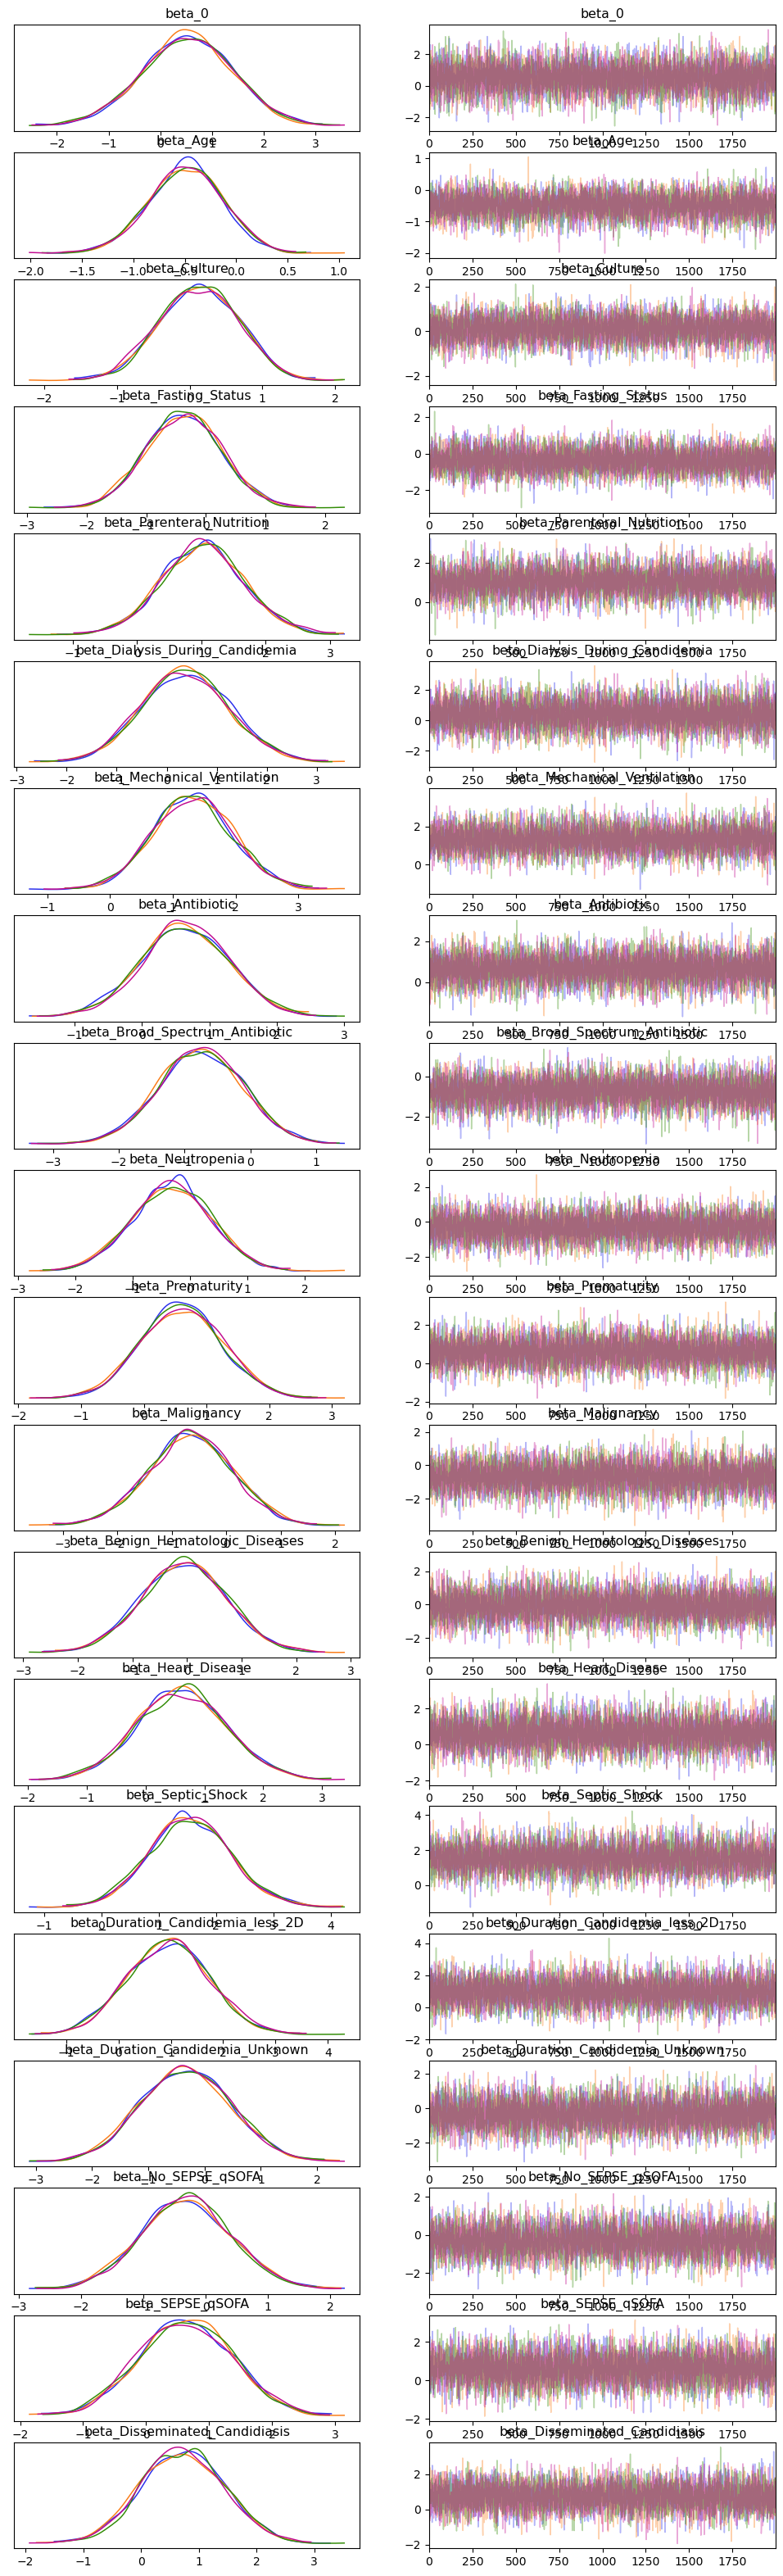

In [207]:
#Plot the traces
az.plot_trace(trace, compact=False)

# Model Assessment

### Posterior Predictive Check

Sampling: [ICU Admissions]


Output()

<Axes: xlabel='ICU Admissions'>

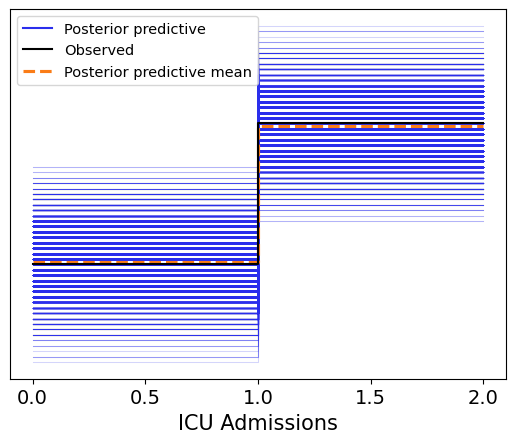

In [212]:
#Sample PPC
with full_model:
    ppc = pm.sample_posterior_predictive(trace, extend_inferencedata=True, random_seed=42)

#Plot the PPC
plt.style.use('arviz-colors')
pm.plot_ppc(trace)

The outcome of the posterior predictions are the same with the last model, indicating that the full model captures the empirical event rate and thus, its considered well balibrated.

### Separation Plot

<Axes: >

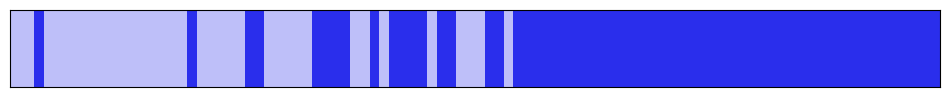

In [216]:
#Graph the separation plot
az.plot_separation(idata=ppc, y="ICU Admissions",figsize=(12,1))

The plot shows how well the full model separates the two classes (0 and 1) based on predicted probabilities. From left to right, the bars clearly transition from mostly light blue to mostly dark blue. This means the model assigns higher predicted probabilities to patients who truly had the event/outcome.</br>
We can observe some dark blue bars mixed into the light zone and vice versa. These represent false negatives and false positives, they are not overly frequent, showing reasonable model performance.

### k̂ Parameter

/Users/diegovonborries/anaconda3/lib/python3.12/site-packages/arviz/plots/khatplot.py:184: FutureWarning: support for DataArrays will be deprecated, please use ELPDData.The reason for this, is that we need to know the numbers of drawssampled from the posterior
  warnings.warn(


<Axes: xlabel='Data Point', ylabel='Shape parameter k'>

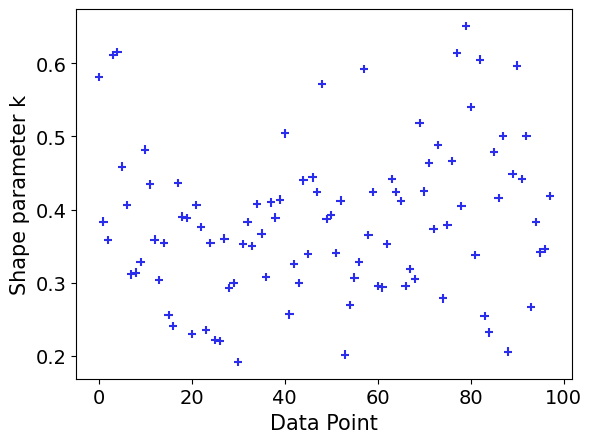

In [221]:
# compute pointwise LOO
loo = az.loo(trace)

#Plot k values
az.plot_khat(loo.pareto_k)

On this model we can observe kappa values greater than the model with relevant features, but as mentioned before for a kappa value to be influent the kappa value must be greater than 0.7, in this case all values are under that threshold.

/Users/diegovonborries/anaconda3/lib/python3.12/site-packages/arviz/plots/khatplot.py:167: FutureWarning: support for arrays will be deprecated, please use ELPDData.The reason for this, is that we need to know the numbers of drawssampled from the posterior
  warnings.warn(


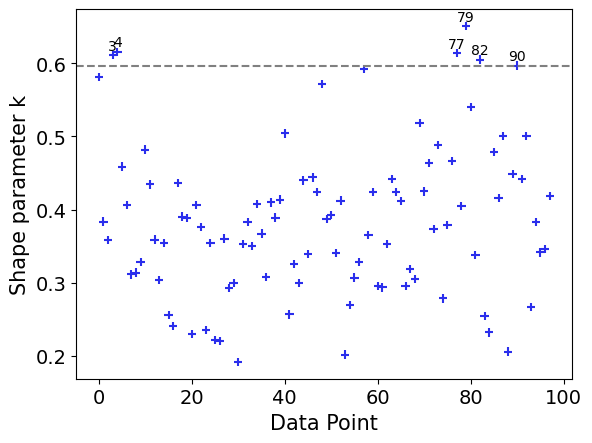

In [228]:
#Let's find the kappa values greater than 0.6

ax= az.plot_khat(loo.pareto_k.values.ravel()) #ravel puts all the pareto values in one single array
sorted_kappas = np.sort(loo.pareto_k.values.ravel())

#Find the observation where the kappa value exceeds the threshold
threshold= sorted_kappas[-6:].min()
ax.axhline(threshold, ls='--', color= 'gray')
influential_obs= data.reset_index()[loo.pareto_k.values >= threshold].index

for i in influential_obs:
    y= loo.pareto_k.values[i]
    ax.text(i, y + 0.007, str(i), ha= 'center', va='baseline')

In [262]:
#Take a look on the info about the subjects with the highest kappa value
data.iloc[influential_obs.values,:]
#Alternative
#data.iloc[list(influential_obs.values),:]

,Age,Gender,Culture,Recent Abdominal Surgery (within 30 days),"Central Venous Device (CVC, PICC, Hickman, Broviac, Semi-Implantable)",Time in ICU,Fasting Status,Parenteral Nutrition,Dialysis During Candidemia,Mechanical Ventilation,...,Catheter Removal Unknown,Catheter Not Removed in the First 3 Days of Candidemia,Catheter Removed in the First 3 Days of Candidemia,Catheter Removed in the First 3 Days of Candidemia - Unknown,Antifungal Response - FAILURE,Antifungal Response <72H,Antifungal Response 4-7 Days,Antifungal Response >7 Days,Antifungal Response - Unknown,ICU
3,177,0,2,0,1,0.0,0,1,1,1,...,0,1,0,0,0,0,0,0,1,0
4,177,1,2,0,1,3.0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
77,6,0,2,0,1,122.0,0,1,0,1,...,0,1,0,0,0,0,0,1,0,1
79,187,0,1,1,1,57.0,1,1,1,1,...,0,0,1,0,0,1,0,0,0,1
82,20,1,1,0,1,9.0,1,1,0,0,...,0,0,1,0,0,0,0,1,0,1
90,104,1,2,0,1,0.0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [274]:
#Print the age of the patients
for i,j in enumerate(data.Age.values[influential_obs.values]):
    year,months=age_converter(j)
    print('Patient %s is %s years and %s months old.' % (i+1,year,months))

Patient 1 is 14 years and 9 months old.
Patient 2 is 14 years and 9 months old.
Patient 3 is 0 years and 6 months old.
Patient 4 is 15 years and 7 months old.
Patient 5 is 1 years and 8 months old.
Patient 6 is 8 years and 8 months old.


Taking a look on the information of the subjects with a k_hat or kappa value greater than 0.6 come from different ages, it's a group of three wemen and 3 men where four of them where admitted to ICU while only two weren't.

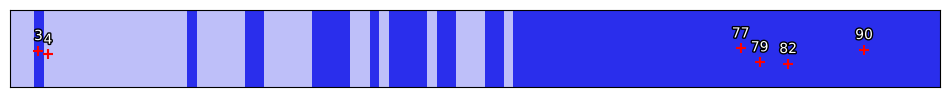

In [277]:
#Find the subjects on the separation plot

#Create the separation plot
ax= az.plot_separation(idata=ppc, y='ICU Admissions', figsize=(12,1))

#Set the y axis position
y= np.random.uniform(low= 0.1, high= 0.7, size= len(influential_obs))

#Marke the highest kappa observation
for x,y in zip(influential_obs, y):
    #Printing of the value
    text= str(x)
    x= x/len(data)
    #Create the mark
    ax.scatter(x=x, y=y, marker= '+', s=50, color='red', zorder=3)
    ax.text(x=x, y= y + 0.1, s=text, color= 'white', ha='center', va='bottom',
           path_effects= [pe.withStroke(linewidth=2, foreground= 'black')])

The red crosses mark the observations with the largest κ diagnostics (≈0.6–0.7); none exceed the common influence threshold of 0.7, so none are classified as influential. Subjects 3 and 90 have ICU = 0 (no ICU admission); subjects 4, 77, 79, and 82 have ICU = 1 (admitted). Subjects 3 and 4 are adjacent on the extreme left of the plot, while 90 appears on the right tail; the other marked cases (77, 79, 82) fall in the high predicted-probability region. Because all kappa values are below 0.7, these points do not materially distort estimation — they simply highlight the individual cases with the largest diagnostics (a mix of true positives and two non-events, one of which the model assigns high risk), which reflects expected model uncertainty rather than model failure.

### Forest Plot

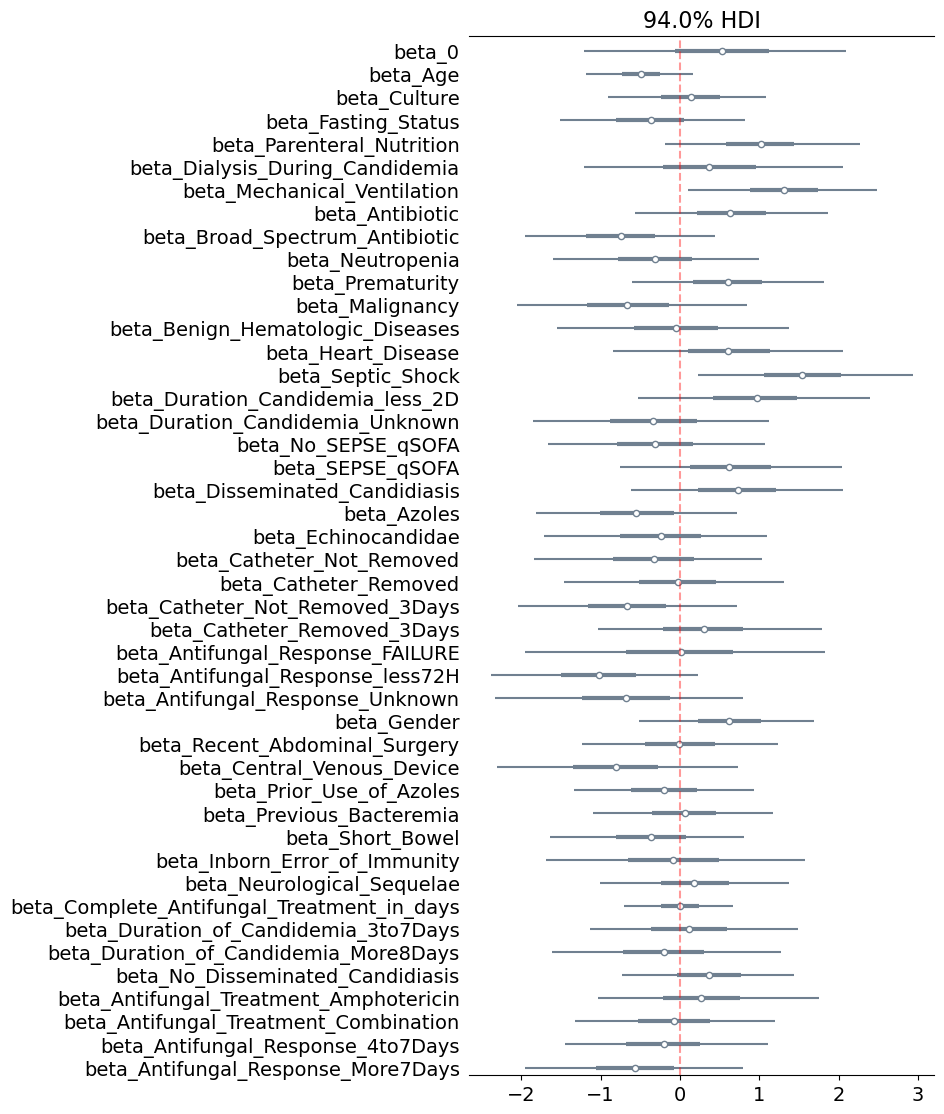

In [291]:
#Graph the Forest plot
az.plot_forest(trace, combined=True, colors= 'slategray', var_names=summary.index[0:45], figsize=(6,13.5))
plt.axvline(x=0, c= 'red', linestyle='--',alpha = 0.4)

The forest plot validates the outcomes from summary, the only two features that do not contain zero on their credible interval are *Mechanical Ventilation* and *Septic Shock*, both of them are on the right side of the forest plot indicating these features increase the odds of being admitted to the ICU.

### Confusion Matrix

In [296]:
#Posterior-mean probability for each patient
y_prob = trace.posterior['p'].mean(('chain','draw')).values

#Bayes optimal hard call
#Element-wise threshold at 0.5 -> True/False.
y_pred= (y_prob > 0.5).astype(int)

#Confussion matrix
print('Confusion Matrix \n',confusion_matrix(data.ICU, y_pred))
print(classification_report(data.ICU, y_pred, digits=3))

Confusion Matrix 
 [[28  8]
 [ 4 58]]
              precision    recall  f1-score   support

           0      0.875     0.778     0.824        36
           1      0.879     0.935     0.906        62

    accuracy                          0.878        98
   macro avg      0.877     0.857     0.865        98
weighted avg      0.877     0.878     0.876        98



The model correctly classified 28 of 36 non-ICU cases (specificity = 77.8%) and 58 of 62 ICU admissions (sensitivity = 93.5%), indicating a strong ability to identify patients who required ICU care.</br>

Precision was high for both classes (0.875 for non-ICU and 0.879 for ICU), showing that the predicted labels closely matched the true outcomes. The F1-scores (0.824 for non-ICU and 0.906 for ICU) further confirm balanced performance between precision and recall, particularly for the ICU class, where accurate identification is clinically most relevant.</br>

Overall accuracy reached 87.8%, and the macro-averaged metrics (precision = 0.877, recall = 0.857, F1 = 0.865) demonstrate that the model performs consistently across both outcome categories. These results indicate that incorporating all features improves discrimination and yields a robust predictive model for ICU admission in pediatric candidemia cases.</br>

### Area Under the Curve

In [300]:
#Creating the dictionary with the relevant measurements
pred_scores= dict(y_true=data.ICU, y_score=y_pred)
#Print AUC
print(f'AUC = {roc_auc_score(**pred_scores):.4f}')

AUC = 0.8566


The model achieved an Area Under the ROC Curve (AUC) of 0.8566, indicating strong overall discriminative ability. An AUC above 0.85 reflects that the model correctly ranks ICU and non-ICU cases with high reliability, further supporting the robustness of the predictive performance obtained with all features included.

# Compare models with LOO-PSIS

This section is dedicated to compare both model to determine which one has a better perfomance, it's intended to use the method Leave One Out using Pareto-smoothed importance sampling (PSIS).

In [32]:
#Compute LOO-PSIS
loo_reduced= az.loo(idata, pointwise=True)
loo_full= az.loo(trace, pointwise=True)

#Compare both models
az.compare({'reduced': loo_reduced, 'full': loo_full},
           ic='loo', scale='log')

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
reduced,0,-56.305782,16.772914,0.000000,1.0,6.374630,0.000000,False,log
full,1,-60.821216,25.137998,4.515434,0.0,7.060751,2.767054,False,log


Before digging into the explanation on how to interpret the outcome, it is vital to highlight that the first model fitted on this notebook, the one that is considering the only the relevant features, is called *reduced* for this analysis, and the model considering all the features is called *full*.</br> 

The interpertation of the outcome to determine which model is better is straight forward, the function *az.compare* places the model with the best performance in the first row. To validate this information and understand the procedure behind this function, we have to take into account the parameters *elpd_loo*, *elpd_diff*, and *weight*. </br>

The interpretation of the *elpd_diff* is based on the highest value, or in this case the less negative is the better model with a better predictive accuracy. In this case the reduced model has the less negative value.</br>

*Elpd_diff* tells if the difference between the models is meaningful, it is calculated as *elpd_loo(reduced)−elpd_loo(full)*, the results shows a difference moderately large in favor of the reduced model, following the interpretation scale (used in the LOO literature, e.g. Vehtari et al. 2017):</br>

- elpd_diff   ---         Interpretation
- 0–1	 --------        negligible
- 1–3	 --------          small
- 3–7	 --------          moderate
- +7	 ---------          large</br>

*P_loo* tells you how complex the model behaves in terms of overfitting and flexibility, not just how many raw parameters it has. The interpretation is:
- Higher p_loo -> more flexible model -> higher risk of overfitting.
- Lower p_loo -> simpler, more regularized model.</br>
The reduced model has lower effective complexity, generalizes better.</br>

In conclusion, the PSIS-LOO comparison indicates that the reduced model provides better out-of-sample predictive performance than the full model.

# Conclusion

Across both Bayesian logistic regression models, *mechanical ventilation* and *septic shock* consistently emerged as the only variables strongly associated with ICU admission. In both forest plots, their posterior distributions were positioned clearly to the right, and their credible intervals did not cross zero, indicating a robust and clinically meaningful increase in the odds of ICU admission for patients presenting with either condition.</br>

The predictive performance of the models further supports these findings. Both versions achieved high accuracy, balanced precision and recall, and strong discriminative ability, with AUC values above 0.80 (0.8047 for the reduced model and 0.8566 for the full model). The confusion matrices and classification reports show particularly strong sensitivity for detecting ICU admissions—an important feature in clinical prediction—while maintaining good specificity for identifying non-ICU cases.</br>

Taken together, the results indicate that although the dataset contains many potential predictors, ICU admission is primarily driven by acute clinical severity indicators rather than demographic or chronic disease factors. The models demonstrate stable performance and provide consistent evidence that *mechanical ventilation* and *septic shock* are the key determinants of ICU requirement in this patient population.

In [308]:
#This is a LOO-PIT assessment, in this case does not apply because is for continous outcomes, is recommended for a Bayesian linear regression
#with relevant_feat_model:
#    ppc = pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=42)

#plt.style.use('arviz-colors')
#pm.plot_loo_pit(idata,  # using arviz InfereceData type 
#                y='ICU Admissions', 
#                color='slategray')
#plt.show()